In [ ]:
!pip install scikit-plot
!pip install tensorflow
!pip install opencv-python

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d deadskull7/fer2013
!unzip fer2013.zip

Saving kaggle.json to kaggle.json
 90% 87.0M/96.6M [00:01<00:00, 91.5MB/s]
100% 96.6M/96.6M [00:01<00:00, 69.8MB/s]
Archive:  fer2013.zip
  inflating: fer2013.csv             


In [ ]:
!pip install keras

In [ ]:
import math
import numpy as np
import pandas as pd
import cv2

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import scikitplot
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

In [ ]:
df = pd.read_csv('/content/fer2013.csv')

emotion_label_to_text = {
  0: 'anger',
  1: 'disgust',
  2: 'fear',
  3: 'happiness',
  4: 'sadness',
  5: 'surprise',
  6: 'neutral'
}


In [ ]:
print(np.sum(df.emotion==6))
print(df.emotion)


6198
0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64


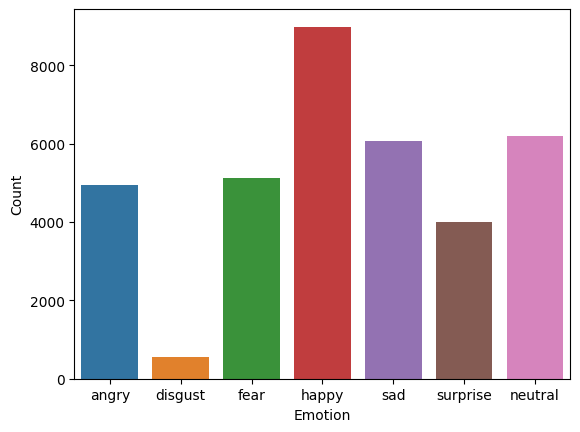

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
emotion_labels_2 = [0, 1, 2, 3, 4, 5, 6]

grouped_data = df.groupby('emotion').size().reset_index(name='count')

# Rysowanie wykresu
sns.barplot(x='emotion', y='count', data=grouped_data, order=emotion_labels_2)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(range(len(emotion_labels)), emotion_labels)
plt.savefig('wykres_slupkowy.png')
plt.show()


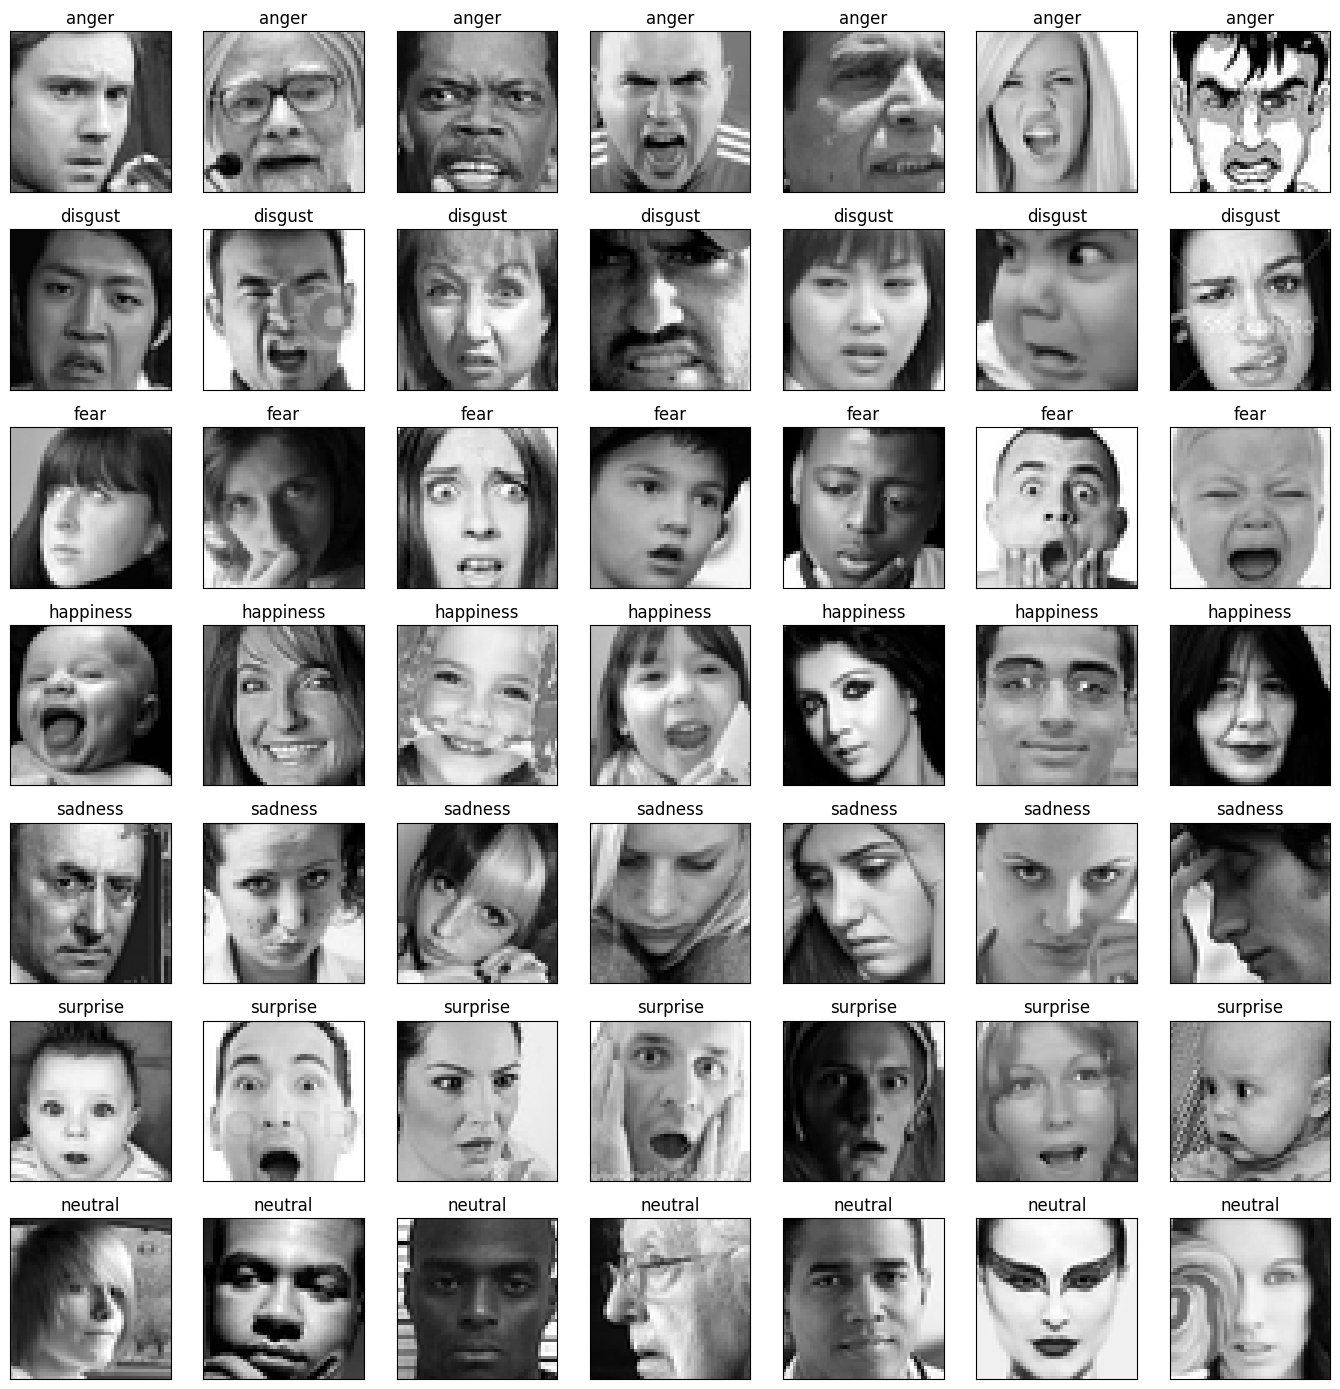

In [ ]:
#Visualize the images of each emotion category

fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
#Chosing emotions to detect in our model

INTERESTED_LABELS = [0, 1, 2, 3, 4, 5]
df = df[df.emotion.isin(INTERESTED_LABELS)]

In [ ]:
#Convert each flattened image into a square 3 dimensional image of size 48x48x1
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

#Stack all images along the 4th dimension because we feed data as batches to our model rather than feeding one image at a time
img_array = np.stack(img_array, axis=0)

#Label encoding categories
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)

#Remapping
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
#Split the data into training and validation set
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf

X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True,
  stratify=img_labels,
  test_size=0.2,
  random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
  X_valid,
  y_valid,
  shuffle=True,
  stratify=y_valid,
  test_size=0.5,
  random_state=42
)

ros = RandomOverSampler()
print('BEFORE')
print("Train:", len(X_train),len(y_train))
print("Valid:", len(X_valid),len(y_valid))
print("Test:", len(X_test),len(y_test))
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_reshaped, y_train)
X_valid_resampled, y_valid_resampled = ros.fit_resample(X_valid_reshaped, y_valid)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test_reshaped, y_test)




BEFORE
Train: 28709 28709
Valid: 3589 3589
Test: 3589 3589


In [ ]:
X_train = X_train_resampled.reshape((-1, 48, 48, 1))
X_valid = X_valid_resampled.reshape((-1, 48, 48, 1))
X_test = X_test_resampled.reshape((-1, 48, 48, 1))
y_train = y_train_resampled
y_valid = y_valid_resampled
y_test = y_test_resampled
print('AFTER')
print("Train:", len(X_train),len(y_train))
print("Valid:", len(X_valid),len(y_valid))
print("Test:", len(X_test),len(y_test))
del df
del img_array
del img_labels

AFTER
Train: 56630 56630
Valid: 6293 6293
Test: 6293 6293


In [ ]:
# Normalizing arrays, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
#MODEL
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [ ]:
#Parameters

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

batch_size = 32 #batch size of 32 performs the best.

epochs = 100

optims = [
  optimizers.Nadam(
      learning_rate=0.001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='Nadam'),

  optimizers.Adam(0.001),
]

In [ ]:
#Training

model = build_net(optimizers.Adam(0.001))

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

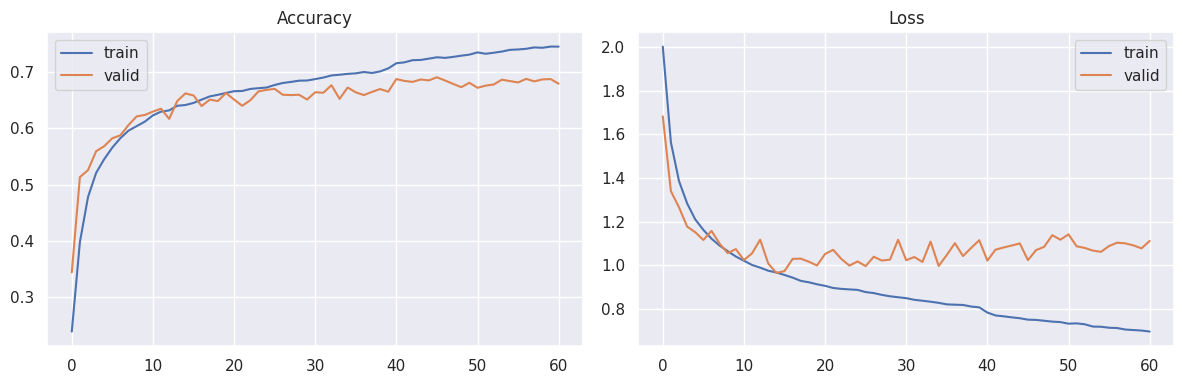

In [ ]:
#plot the training and validation metrics

sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

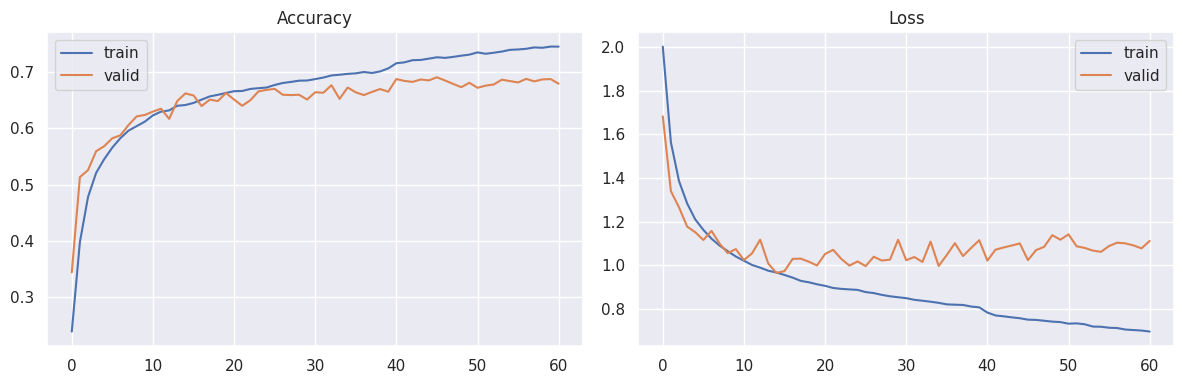

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Wykres dokładności
axes[0].plot(history.epoch, history.history['accuracy'], label='train')
axes[0].plot(history.epoch, history.history['val_accuracy'], label='valid')
axes[0].set_title('Accuracy')

# Wykres straty
axes[1].plot(history.epoch, history.history['loss'], label='train')
axes[1].plot(history.epoch, history.history['val_loss'], label='valid')
axes[1].set_title('Loss')

# Dodanie legendy
axes[0].legend()
axes[1].legend()

# Dostosowanie układu
plt.tight_layout()

# Zapisz wykres do pliku
plt.savefig('epoch_history_dcnn_2.png')

# Pokaż wykres
plt.show()

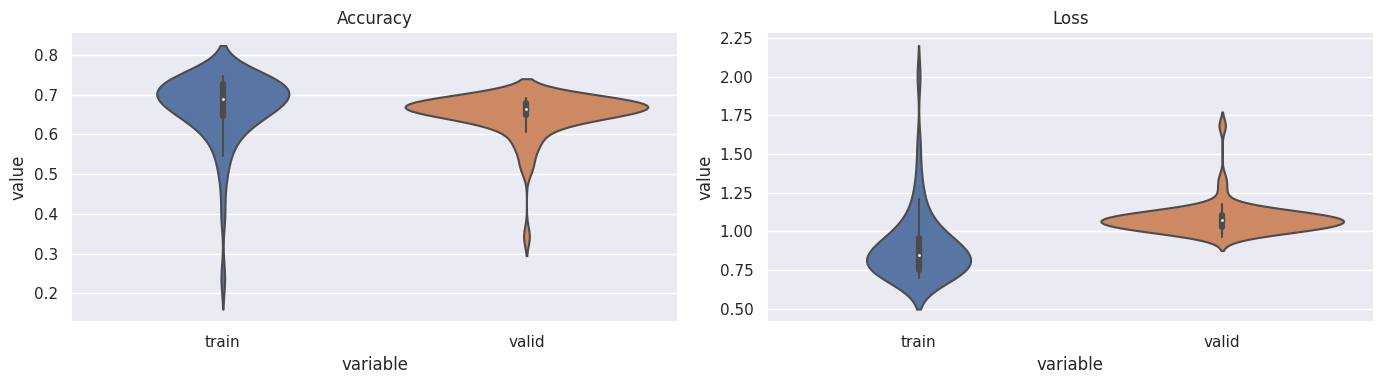

In [ ]:
#plot the distribution of training and validation metrics

df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 3s 22ms/step
total wrong validation predictions: 1118


              precision    recall  f1-score   support

           0       0.56      0.72      0.63       495
           1       0.67      0.78      0.72        55
           2       0.63      0.42      0.50       512
           3       0.91      0.84      0.88       899
           4       0.60      0.49      0.54       608
           5       0.73      0.84      0.78       400
           6       0.61      0.75      0.67       620

    accuracy                           0.69      3589
   macro avg       0.67      0.69      0.68      3589
weighted avg       0.69      0.69      0.68      3589



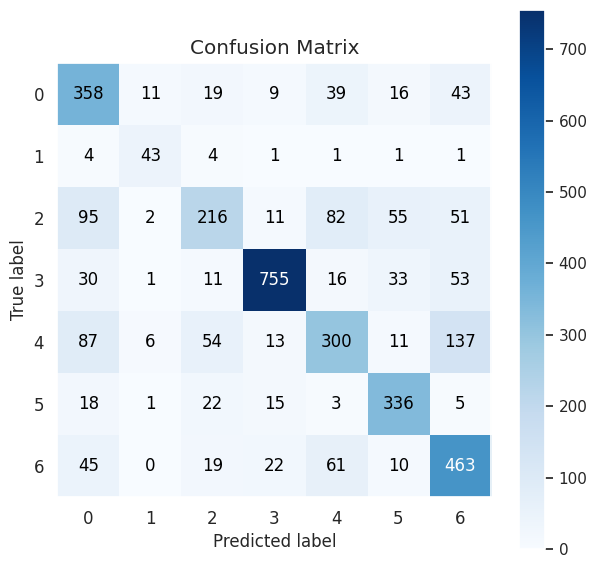

In [ ]:
#visualize a confusion-matrix

yhat_valid_probs = model.predict(X_valid)
yhat_valid = np.argmax(yhat_valid_probs, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [ ]:
model.save("model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
model_path = 'model2.h5'

# Załaduj model
model = load_model(model_path)

# evaluation = model.evaluate(test_generator)

predicted_probabilities = model.predict(X_test)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
print(predicted_probabilities)
print(predicted_labels)
print(y_test)
labels_true = np.argmax(y_test,  axis=1)
print(labels_true)
accuracy = accuracy_score(labels_true, predicted_labels)
print("Dokładność modelu na danych testowych: {:.2f}%".format(accuracy * 100))

# Wyświetl raport klasyfikacyjny
classification_report_result = classification_report(labels_true, predicted_labels)
print("Raport klasyfikacyjny:\n", classification_report_result)


113/113 [==============================] - 1s 7ms/step
[[1.46836997e-03 1.22170696e-09 9.74288702e-01 ... 2.78748758e-03
  1.44447144e-02 9.87059553e-04]
 [2.90531083e-04 1.33059723e-08 8.27811006e-03 ... 4.27162391e-04
  9.89451945e-01 1.45252666e-03]
 [9.13727105e-01 1.08978595e-04 6.62262738e-02 ... 2.97626178e-03
  1.63194072e-02 3.23380402e-04]
 ...
 [4.07744765e-01 1.24409207e-05 1.37263715e-01 ... 1.58710688e-01
  4.44142055e-03 2.91214436e-01]
 [9.62579846e-02 4.53058465e-06 6.60033524e-02 ... 8.36720407e-01
  1.58588282e-05 9.19366430e-04]
 [2.73959152e-02 3.03764932e-06 1.84424281e-01 ... 4.57674116e-01
  7.23745069e-03 3.16612780e-01]]
[2 5 0 ... 0 4 4]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[2 5 0 ... 2 4 2]
Dokładność modelu na danych testowych: 68.85%
Raport klasyfikacyjny:
               precision    recall  f1-score   support

           0       0.56     